In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from sklearn.model_selection import train_test_split
import cv2

from matplotlib.collections import LineCollection

In [5]:
N = 500 # dataset size
theta = np.random.rand(N) * 2 * np.pi
x1 = np.sqrt(theta+np.random.rand(N)/10) * np.cos(theta)
y1 = np.sqrt(theta+np.random.rand(N)/10) * np.sin(theta)

shift = np.pi/1.5 # shifting theta
x2 = np.sqrt(theta+np.random.rand(N)/10) * np.cos(theta+shift)
y2 = np.sqrt(theta+np.random.rand(N)/10) * np.sin(theta+shift)

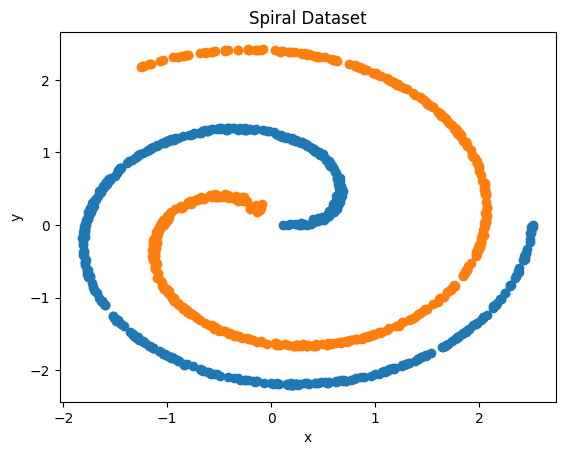

In [58]:
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Spiral Dataset")
plt.savefig("./docs/spiral.jpg")

In [7]:
label = np.array([0]*N+[1]*N)
data = np.hstack([np.vstack([x1, y1]), np.vstack([x2, y2])]).T
# data.shape (B, (x, y))

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2)

In [9]:
class Sample(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = torch.tensor(x).to(torch.float)
        self.y = torch.tensor(y).to(torch.long)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self): return self.x.shape[0]

train_sample = Sample(X_train, y_train)
test_sample = Sample(X_test, y_test)

train_loader = DataLoader(train_sample, batch_size=32, shuffle=True)
test_loader = DataLoader(test_sample, batch_size=N, shuffle=False)

In [48]:
net = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Linear(5, 2),
    nn.Tanh(),
    nn.Linear(2, 2)
) #-> This is bad for visualization?(maybe)

optimizer = torch.optim.SGD(net.parameters(), lr=0.01, weight_decay=0.01)

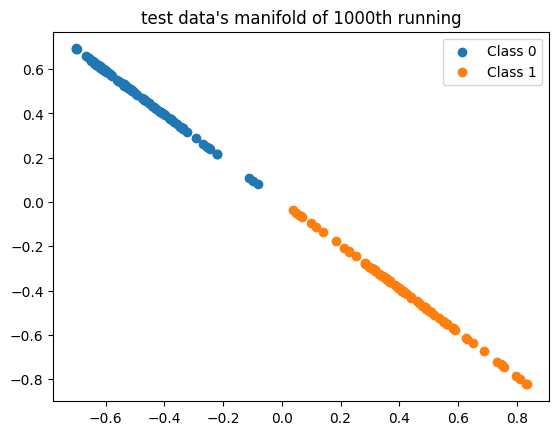

In [51]:
frames = []

fig, ax = plt.subplots()

def manifold_of_nth_step(net, step):
    without_last = nn.Sequential(*list(net.children())[:-1])
    x, y = next(iter(test_loader))

    ax.clear()
    ax.set_title(f"test data's manifold of {step}th running")
    for i in range(2):
        label_i_item = x[y == i] # Select item by label
        manifold = without_last(label_i_item)
        xx = manifold[:, 0].detach().numpy()
        yy = manifold[:, 1].detach().numpy()
        ax.scatter(xx, yy, label=f"Class {i}")
    ax.legend()

    buf = BytesIO()
    plt.savefig(buf)
    return Image.open(buf).convert("RGB")

# Training Stage
for i in range(1001):
    loss_accum = 0
    for n, (x, y) in enumerate(train_loader):
        yhat = net(x)
        optimizer.zero_grad(set_to_none=True)
        loss = F.cross_entropy(yhat, y)
        loss_accum += loss.item()
        loss.backward()
        optimizer.step()
    if i%10 == 0: # record manifold before last layer on every 10 steps.
        frames.append(manifold_of_nth_step(net, i))
    if i%100==0:
        frames[-1].save(f"docs/manifold_{i}.jpg")
    # print(f"loss: {loss_accum/n:.5f}")

In [52]:
def make_video(video_name, frames):
    fps = 5
    width, height = frames[0].size

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video = cv2.VideoWriter(video_name, fourcc, fps, (width, height))

    for img in frames:
        frame = np.array(img)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        video.write(frame)
    video.release()

In [53]:
video_name = "manifold.mp4"
make_video(video_name, frames)

In [54]:
from IPython.display import Video
Video(video_name)

In [56]:
grid_x,grid_y = np.meshgrid(np.linspace(-1,1,20),np.linspace(-1,1,20))
grid = np.stack([grid_x, grid_y], axis=2)

without_last = nn.Sequential(*(list(net.children()))[:-1])
grid_after = without_last(torch.tensor(grid).to(torch.float).reshape(-1, 2)).contiguous().reshape(20, 20, 2).detach()
grid_x_after = grid_after[:, :, 0].numpy()
grid_y_after = grid_after[:, :, 1].numpy()

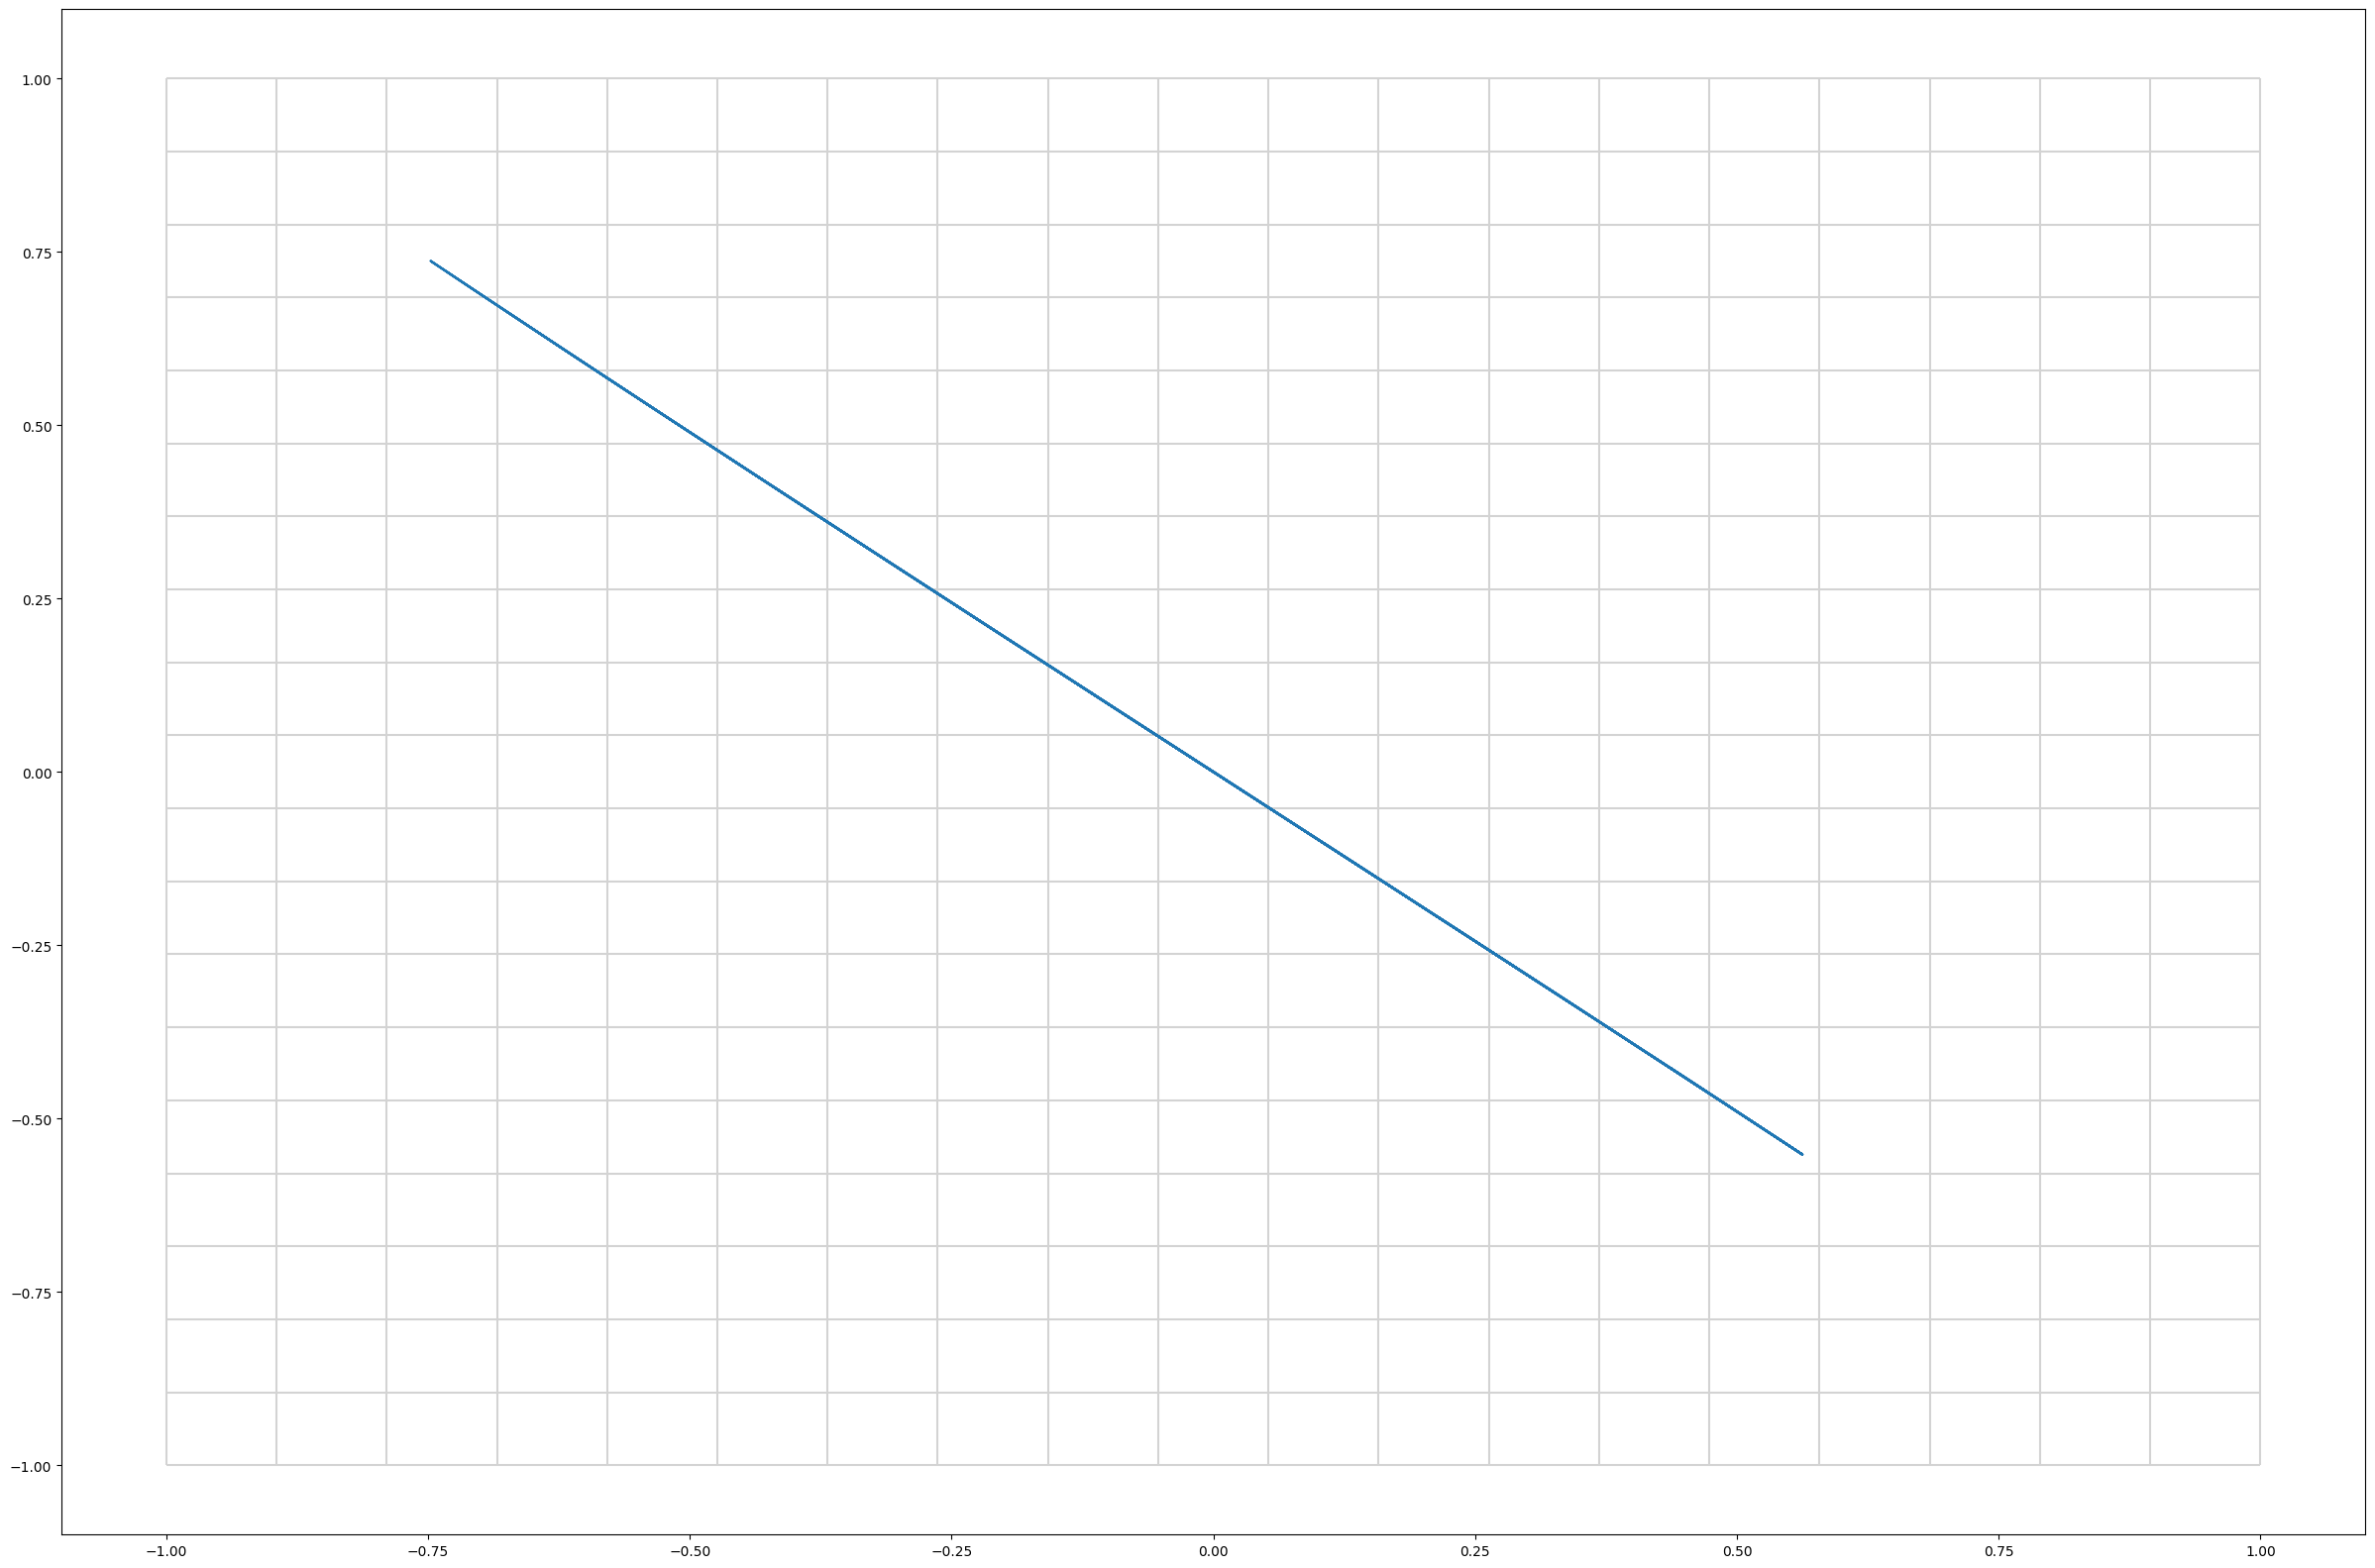

In [57]:
def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

fig, ax = plt.subplots(figsize=(30, 20))

plot_grid(grid_x, grid_y, ax=ax, color="lightgrey")
plot_grid(grid_x_after, grid_y_after, ax=ax)